
**Install requirements**

In [4]:
!python -m pip install -U pip
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 1.5MB 14.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 734.6 MB 23 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.8.1+cu101 requires torch==1.7.0, but you have torch 1.3.1 which is incompatible.


     |████████████████████████████████| 4.0 MB 13.2 MB/s 
     |████████████████████████████████| 753.4 MB 22 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


     |████████████████████████████████| 630 kB 14.3 MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110300 sha256=d914bde469d3428347a230ec70e5dd122deb27cb28b42f9cf44fcd3b4548a2fc
  Stored in directory: /root/.cache/pip/wheels/54/a4/d6/6a2877ff61c41f6cbeced16ca150601820ed3f8b27cb7faf8d
Successfully built Pillow-SIMD


**Imports**

In [1]:
import os
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from torchvision.datasets import VisionDataset
from PIL import Image
import os
import os.path
import sys
import matplotlib.pyplot as plt
from torchvision.models import alexnet
import numpy as np
from PIL import ImageDraw
import matplotlib.image as mpimg

**Function used to plot the loss and accuracy**

In [2]:
def plotting(loss_train, loss_val, acc_train, acc_val):
  
  epochs=len(loss_train)
  x=[i+1 for i in range(epochs)]
  x_div=int(epochs/6)
  xdisp=[i for i in range(epochs) if i%x_div==1]
  plt.figure()
  plt.plot(x, loss_train, 'r', label='Training loss')
  plt.plot(x, loss_val, 'b', label='Validation loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.xticks(xdisp)
  plt.savefig('Losses', format='png')
  plt.figure()
  plt.plot(x, acc_train, 'r', label='Training accuracy')
  plt.plot(x, acc_val, 'b', label='Validation accuracy')
  plt.legend()
  plt.xticks(xdisp)
  plt.xlabel('Epochs')

**Functions implementing the logic to load the database**

In [3]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Caltech(VisionDataset):

    def __init__(self, root, split, transform=None, transform_train=None, transform_val=None, train_or_val=None):

    #In this implementation the first row of the training file contains a picture of the training set, and the second row a picture of the validation set.
    #Since pictures of the same classes are in sequential rows, this ensures the same number of pictures for each class in the training and validation set.
    #I used it for the 4th section of the homework since I find this logic of implementation a bit easier when exploiting the data augmentation technique.  
    #However, in the comments another implementation is introduced, which uses the standard train test split function with stratify.

        self.images =[]
        self.images_val=[]
        self.indexes = {}
        super(Caltech, self).__init__(root, transform=transform)
        self.split = split
        self.train_or_val=train_or_val
        self.transform=transform
        self.transform_train=transform_train
        self.transform_val=transform_val
        skip = False
        filenames = open(root.split("/")[0]+"/"+split+".txt", "r")
        i=0
        ind='TRAIN'
        for filename in filenames.readlines():
            skip=False
            for class_ignored in  ["BACKGROUND_Google"]:
                if filename.startswith(class_ignored):
                    skip=True
                    break
            if skip:
                continue
            label = filename.split("/")[0]
            if self.split=='train':
              if ind=='TRAIN':
                self.images.append((pil_loader(root+"/"+filename.rstrip()), label))
              else:
                self.images_val.append((pil_loader(root+"/"+filename.rstrip()), label))
            else:
              self.images.append((pil_loader(root+"/"+filename.rstrip()), label))
            if label not in self.indexes.keys():
                self.indexes[label]=i
                i+=1
            if self.split=='train':
              if ind=='TRAIN':
                ind='VAL'
              else:
                ind='TRAIN'

    def __getitem__(self, index):

        train_or_val=self.train_or_val
        if train_or_val=='train':
            image, label = self.images[index][0], self.indexes[self.images[index][1]]
            image=self.transform_train(image)
            return image, label
        if train_or_val=='val':
            image, label = self.images_val[index][0], self.indexes[self.images[index][1]]
            image=self.transform_val(image)
            return image, label
        else:
            image, label = self.images[index][0], self.indexes[self.images[index][1]]
            image=self.transform(image)
            return image, label

    def __len__(self):

        if self.train_or_val=='val':
            return len(self.images_val)
        else:
            return len(self.images)



**Code used to visualize preprocessed pictures**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


65
label


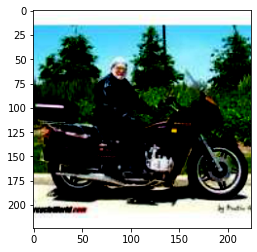

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


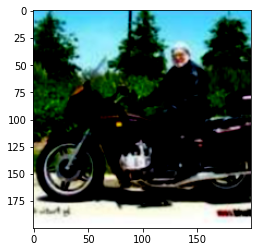

In [ ]:
num=145
arr=train[num][0][0].cpu().detach().numpy()
arr_transf=train[num][0][1].cpu().detach().numpy()
label=train[num][1]
print(label)
print('label')

arr2=np.transpose(arr, (1,2,0))
arr_transf2=np.transpose(arr_transf, (1,2,0))
plt.imshow(arr2)
plt.show()
plt.figure()
plt.imshow(arr_transf2)
plt.show()


**Function used to load the database**

In [4]:
def init(pre_trained, batch_size):

  if pre_trained==True:

    train_transform = transforms.Compose([transforms.Resize(256),    
                                        transforms.CenterCrop(224),  
                                        #transforms.RandomHorizontalFlip(p=0.5),
                                        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                        #transforms.RandomCrop(size=130),                                                        
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    val_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  
    test_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   
                                    
  if pre_trained==False:

    train_transform = transforms.Compose([transforms.Resize(256),     
                                        transforms.CenterCrop(224),                                                                
                                        #transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor(), 
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
    ])
    val_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                         ])
    test_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                         ])

  if not os.path.isdir('./Caltech101'):
    !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !mv 'Homework2-Caltech101' 'Caltech101'
  DATA_DIR = 'Caltech101/101_ObjectCategories'

  train_dataset = Caltech(DATA_DIR, split='train', train_or_val='train', transform_train=train_transform)
  val_dataset= Caltech(DATA_DIR, split='train', train_or_val='val', transform_val=val_transform)
  test_dataset = Caltech(DATA_DIR, split='test', transform=test_transform)
  
  '''
  labels=[]
  for i in range(len(train_dataset)):
    labels.append(train_dataset[i][1])
  from sklearn.model_selection import train_test_split
  train, val=train_test_split(train_dataset, stratify=labels, test_size=0.5, random_state=42)
  '''

  print('Train Dataset: {}'.format(len(train_dataset)))
  print('Valid Dataset: {}'.format(len(val_dataset)))
  print('Test Dataset: {}'.format(len(test_dataset)))

  # Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)  

  return train_dataloader, val_dataloader, test_dataloader, train_dataset, val_dataset, test_dataset

**Training, validation and test**

In [15]:
def train_net(net, layer, train_dataloader,  val_dataloader, test_dataloader, train_dataset, val_dataset, test_dataset, NUM_CLASSES, BATCH_SIZE,LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY):

  criterion = nn.CrossEntropyLoss() 

  if layer=='all':
    parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
  if layer=='fully':
    parameters_to_optimize=net.classifier.parameters()
  if layer=='conv':
    parameters_to_optimize=net.features.parameters()

  #optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  optimizer=optim.Adadelta(parameters_to_optimize, lr=LR)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  print('preparing validation!')

  cudnn.benchmark 

  current_step = 0
  val_acc_list=[]
  val_loss_list=[]
  train_loss_list=[]
  train_acc_list=[]

  for epoch in range(NUM_EPOCHS):

    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    net = net.to(DEVICE)
    net.eval()
    running_corrects = 0
    train_loss=0

    #Validation is made before training in order to check the accuracy of pretrained models

    for images, labels in (val_dataloader):

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = net(images)
      _, preds = torch.max(outputs.data, 1)
      local_loss = criterion(outputs, labels)
      train_loss+=local_loss.item()
      running_corrects += torch.sum(preds == labels.data).data.item()

    train_loss=train_loss/len(val_dataloader)
    print('Validation Loss: {}'.format(train_loss))
    accuracy = running_corrects / float(len(val_dataset))
    print('Validation Accuracy: {}'.format(accuracy))
    val_acc_list.append(accuracy)
    val_loss_list.append(train_loss)

    running_corrects = 0
    train_loss=0

    for images, labels in train_dataloader:     

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      net.train() 
      optimizer.zero_grad() 
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss+=loss.item()
      loss.backward()
      optimizer.step() 
      current_step += 1
      _, preds = torch.max(outputs.data, 1)
      running_corrects += torch.sum(preds == labels.data).data.item()

    train_loss=train_loss/len(train_dataloader)
    print('Training Loss: {}'.format(train_loss))
    accuracy = running_corrects / float(len(train_dataset))
    print('Training Accuracy: {}'.format(accuracy))
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    scheduler.step()

  #Testing

  net = net.to(DEVICE) 
  net.eval() 
  running_corrects = 0

  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = net(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = running_corrects / float(len(test_dataset))
  print('Test Accuracy: {}'.format(accuracy))

  return train_loss_list, train_acc_list, val_loss_list, val_acc_list

**Hyperparameters**

In [13]:
DEVICE = 'cuda'
NUM_CLASSES = 101
BATCH_SIZE = 10
LR = 1e-1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 50
STEP_SIZE = 30
GAMMA = 0.1
LOG_FREQUENCY = 10
pre_trained=False
parameters='all'

**Loading, training, evaluating, testing the network and plotting the loss and the accuracy**

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893
preparing validation!
Starting epoch 1/50, LR = [0.1]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Validation Loss: 6.908817611891648
Validation Accuracy: 0.0
Training Loss: 5.145784557896914
Training Accuracy: 0.08333333333333333
Starting epoch 2/50, LR = [0.1]
Validation Loss: 4.33459444580407
Validation Accuracy: 0.14661134163208853
Training Loss: 4.283825204446654
Training Accuracy: 0.1372752420470263
Starting epoch 3/50, LR = [0.1]
Validation Loss: 4.056140679737617
Validation Accuracy: 0.1739280774550484
Training Loss: 3.8528238456554478
Training Accuracy: 0.2071230982019364
Starting epoch 4/50, LR = [0.1]
Validation Loss: 3.517895984225746
Validation Accuracy: 0.23098201936376211
Training Loss: 3.530311328729544
Training Accuracy: 0.2479253112033195
Starting epoch 5/50, LR = [0.1]
Validation Loss: 3.5948895609841265
Validation Accuracy: 0.22856154910096818
Training Loss: 3.336553071196929
Training Accuracy: 0.274896265560166
Starting epoch 6/50, LR = [0.1]
Validation Loss: 3.256072262111298
Validation Accuracy: 0.301521438450899
Training Loss: 3.142744484244746
Training Accur

  0%|          | 0/290 [00:00<?, ?it/s]

Training Loss: 0.005075123694013268
Training Accuracy: 0.9972337482710927


100%|██████████| 290/290 [00:05<00:00, 57.91it/s]


Test Accuracy: 0.5914275838230211


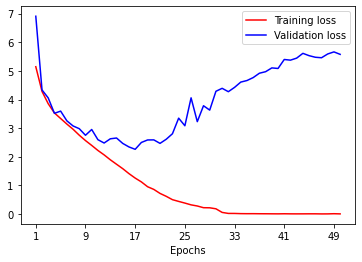

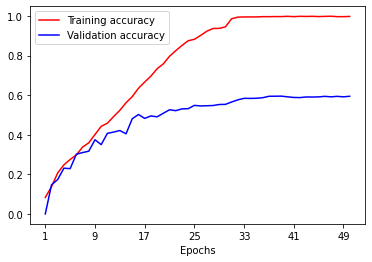

In [16]:
train_dataloader, val_dataloader, test_dataloader,train,val,test=init(pre_trained, BATCH_SIZE)

import torchvision.models as models
net=models.alexnet(pretrained=False).to(DEVICE)
net.fc = nn.Linear(512, 101)

train_loss_list, train_acc_list, val_loss_list, val_acc_list=train_net(net, parameters, train_dataloader, val_dataloader, test_dataloader, train, val, test, NUM_CLASSES, BATCH_SIZE,LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY)
plotting(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

In [11]:
len(val)

2892

In [2]:
import torchvision.models as models
net=models.alexnet(pretrained=True)

In [3]:
print(net)
net.classifier.

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 